## Multi-generation climate model inter-comparison

This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from various model generations and use [`xskillscore`](https://github.com/raybellwaves/xskillscore) to calculate model skill with respect to NCEP Reanalysis 

### Instructions for activated the Jupyter kernel for the `cmip6hack-multigen` conda environment

In a Jupyterlab terminal, navigate to the `/cmip6hack-multigen/` folder and run the command:
```bash
source spinup_env.sh
```
which will create the `cmip6hack-multigen` conda environment and install it as a python kernel for jupyter.

Then, switch the kernel (drop-down menu in the top right hand corner) to cmip6hack-multigen and restart the notebook.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


## Data catalogs

In [2]:
col_dict = {}

mip_ids = ['far', 'sar', 'tar', 'cmip3', 'cmip5', 'cmip6']

for col_name in mip_ids:
    if 'ar' in col_name:
        col = intake.open_esm_datastore(f"https://storage.googleapis.com/ipcc-{col_name}/pangeo-{col_name}.json")
    else:
        col = intake.open_esm_datastore(f"https://storage.googleapis.com/cmip6/pangeo-{col_name}.json")
    col_dict[col_name] = col

## The task at hand

- Loop through the `source_id` for `experiment_id == 'historical'`
- For each model:
    - select only a single ensemble member (at least for now)
    - Take a slice (e.g. `time=slice('1981', '2010')`) and compute time average over that slice (date range consistent with the long-term climatology of the NCEP reanalysis, to which we are comparing
    - Regrid the `tas` data to a common grid
    - drop redundant variables (like "height: 2m")
    - concatenate to ensemble dataset along `ensemble` dimension

### Defining a regridding function

In [3]:
# Choose how much to coarsen data
coarsen_size = 2

# Define the common target grid axes
dlon, dlat = 1., 1.
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90.+dlat/2., 90., dlat)),
                     'lon': (['lon'], np.arange(0.+dlon/2., 360., dlon)),})

# Regridding function
def regrid_to_common(ds, ds_out):
    """
    Regrid from rectilinear grid to common grid
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True, reuse_weights=True)
    return regridder(ds)

In [4]:
Rearth = 6.378E6   # radius of Earth in meters
# a DataArray that gives grid cell areas on the lat/lon grid (in units of m^2)
area = (np.deg2rad(dlat)*Rearth) * (np.deg2rad(dlon)*Rearth*np.cos(np.deg2rad(ds_out.lat))) * xr.ones_like(ds_out.lon)

# coarsen
area = area.coarsen({'lat': coarsen_size, 'lon': coarsen_size}, boundary='exact').mean()

### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [5]:
varnames = ['pr']
time_slice = slice('1981', '2010') # date range consistent with NCEP reanalysis long-term-mean

In [6]:
# For converting units for precip output
cm_to_m = 1.e-2
rho_water = 1.e3
day_in_s = (24.*60.*60.)

In [7]:
# reverse lat list
reverse_list = [
    'SAR.MPIfM.MPIfM-01.historical.Amon.gn',
    'TAR.MPIfM.MPIfM.historical.Amon.gn',
    'CMIP3.IPSL.ipsl_cm4.historical.Amon.gn',
    'CMIP3.MOHC.ukmo_hadcm3.historical.Amon.gn',
    'CMIP5.MOHC.HadCM3.historical.Amon.gn'
]

In [8]:
ds_dict = {}

for mip_id in tqdm(mip_ids):
    ds_dict[mip_id] = {}
    for varname in varnames:
        print("\n",mip_id, varname)
        col = col_dict[mip_id]
        cat = col.search(
            experiment_id='historical',
            variable_id=varname,
            member_id='r1i1p1f1',# choose first ensemble member only (for now)
            table_id='Amon'
        )
        
        if cat.df.size == 0: continue

        dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

        if mip_id == 'sar' and varname == 'tas':
            dset_dict_og = dset_dict
            
        ds_dict[mip_id][varname] = {}
        for key, ds in dset_dict.items():            
            # rename spatial dimensions if necessary
            if ('longitude' in ds.dims) and ('latitude' in ds.dims):
                ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
                
            ds = xr.decode_cf(ds) # Need this temporarily because setting 'decode_times': True appears broken
            ds = ds.squeeze() # get rid of member_id (for now)
            
            # take long-term mean
            try:
                timeave = ds.sel(time=time_slice).mean(dim='time', keep_attrs=True)
            except:
                # A few cases of weird cftime stuff going on...
                print("Weird time units breaks ds.sel(time=time_slice)")
                continue
            
            # modify pre-CMIP6 chunks
            if mip_id != 'cmip6':
                timeave = timeave.chunk({'lat':timeave['lat'].size, 'lon':timeave['lon'].size})
            
            # regrid to common grid
            ds_new = regrid_to_common(timeave[varname], ds_out)

            # Add metadata and apply various corrections
            if mip_id == 'cmip6':
                # Correct MCM-UA precipitation due to broken units (Ron Stouffer, personal communication)
                if ('MCM-UA' in ds.attrs['parent_source_id']) and (varname == 'pr'):
                    # convert from cm/day to kg/m^2/s
                    ds_new *= (cm_to_m * rho_water / day_in_s)
                    
                if ('THU-CIESM' in ds.attrs['parent_source_id']) and (varname == 'pr'):
                    continue # seems to be wrong units?

            ds_new.attrs['name'] = "-".join(key.split(".")[1:3])
            
            if key in reverse_list:
                # TEMPORARY FIX: Correct models which inexplicably have latitude flipped
                ds_new['lat'].values = ds_new['lat'].values[::-1]
            
            # drop redundant variables (like "height: 2m")
            for coord in ds_new.coords:
                if coord not in ['lat','lon']:
                    ds_new = ds_new.drop(coord)

            # Add ensemble as new dimension
            ds_new = ds_new.expand_dims({'ensemble': np.array([ds_new.attrs['name']])}, 0)

            # We should keep the metadata!!!
            ds_new.attrs['mip_id'] = mip_id
            ds_new = ds_new.coarsen({'lat': coarsen_size, 'lon': coarsen_size}, boundary='exact').mean()
            
            ds_dict[mip_id][varname][key] = ds_new  # add this to the dictionary


 far pr
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 3 group(s)
Reuse existing file: bilinear_40x48_180x360_peri.nc
Reuse existing file: bilinear_72x96_180x360_peri.nc
Reuse existing file: bilinear_24x36_180x360_peri.nc

 sar pr
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 8 group(s)
Reuse existing file: bilinear_32x64_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_73x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear

In [9]:
# Create a single dictionary whose keys are the MIP id
#  Each item in the dict will be a single xr.Dataset combining all data from each MIP generation
ens_dict = {}
for mip_id in mip_ids:
    mipdataset = xr.Dataset()
    for varname in varnames:
        if varname in ds_dict[mip_id]:
            vardataarray = xr.concat([ds for name, ds in ds_dict[mip_id][varname].items()], dim='ensemble')
            mipdataset[varname] = vardataarray
    
    ensmean = mipdataset.mean(dim='ensemble', skipna=True)
    mipdataset = xr.concat([ensmean.expand_dims({'ensemble': np.array(['ens-mean'])}), mipdataset], dim='ensemble')
    mipdataset.attrs['name'] = mip_id
    ens_dict[mip_id] = mipdataset

ens_dict

{'far': <xarray.Dataset>
 Dimensions:   (ensemble: 4, lat: 90, lon: 180)
 Coordinates:
   * lon       (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
   * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * ensemble  (ensemble) object 'ens-mean' 'GFDL-GFDL' 'UKTR-UKTR' 'GISS-GISS'
 Data variables:
     pr        (ensemble, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
 Attributes:
     name:     far,
 'sar': <xarray.Dataset>
 Dimensions:   (ensemble: 9, lat: 90, lon: 180)
 Coordinates:
   * lon       (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
   * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * ensemble  (ensemble) object 'ens-mean' ... 'HCCPR-HCCPR-02'
 Data variables:
     pr        (ensemble, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
 Attributes:
     name:     sar,
 'tar': <xarray.Dataset>
 Dimensions:   (ensemble: 7, lat: 90, lon: 180)
 Coordin

## Some 'observational' reference data to compare models against

We will use long-term mean climatology from NCEP reanalysis (because it's easy)

In [10]:
# Paths gotten from:
# https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.surface.html
# https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.surfaceflux.html

ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_paths_dict = {"tas": "surface/air.mon.ltm.nc",
                   "psl": "surface/slp.mon.ltm.nc",
                   "pr": "surface_gauss/prate.sfc.mon.ltm.nc",
                   "uas": "surface/uwnd.mon.ltm.nc",
                   "vas": "surface/vwnd.mon.ltm.nc"}

def convert_ncep_units_to_cf(da):
    if da.attrs['units'] == "degC":
        da += 273.15
        da.attrs['units'] = "K"
    elif da.attrs['units'] == "millibars":
        da *= 100.
        da.attrs['units'] = "Pa"
    return da

ncep = xr.Dataset()
for varname, path in ncep_paths_dict.items():
    # Check that we read in same variables as models
    if varname not in varnames: continue
    
    ncep_ds = xr.open_dataset(ncep_url + path)
    ncep_var_name = path.split("/")[1].split(".")[0]
    
    # Long-term monthly climatology 1981-2010
    ncep_var_native = ncep_ds[ncep_var_name]
        
    # Convert NCEP data to CF units
    ncep_var_native = convert_ncep_units_to_cf(ncep_var_native)
        
    # Long-term mean 1981-2010
    ncep_var_native = ncep_var_native.mean(dim='time', keep_attrs=True)
        
    # Regrid to common grid
    ncep_var_regridded = regrid_to_common(ncep_var_native, ds_out)
    
    # keep all the original attributes
    ncep_var_regridded.attrs.update(ncep_ds.attrs)
    ncep_var_regridded.attrs.update(ncep_var_native.attrs)
    
    # Coarsen
    ncep_var_regridded = ncep_var_regridded.coarsen({'lat':coarsen_size, 'lon': coarsen_size}, boundary='exact').mean()
    ncep[varname] = ncep_var_regridded

/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_94x192_180x360_peri.nc


Here, we consider the ECMWF ReAnalysis (ERA) dataset.

In [11]:
time_slice

slice('1981', '2010', None)

In [12]:
era_native = xr.open_dataset("../data/interim/reanalysis/ERA5_mon_2d.nc", chunks={'time': 1})

era_shift_native = era_native.sel(time=slice('1988', '2018')).mean(dim='time', keep_attrs=True)
era_shift_native = era_shift_native.rename({'msl': 'psl', 't2m': 'tas', 'tp':'pr', 'latitude':'lat', 'longitude':'lon'})
era_shift_native['pr'] *= 1000./(24.*60.*60.)
era_shift = regrid_to_common(era_shift_native, ds_out)
era_shift.attrs.update(era_shift_native.attrs)
era_shift = era_shift.coarsen({'lat':coarsen_size, 'lon': coarsen_size}, boundary='exact').mean()

era_native = era_native.sel(time=time_slice).mean(dim='time', keep_attrs=True)
era_native = era_native.rename({'msl': 'psl', 't2m': 'tas', 'tp':'pr', 'latitude':'lat', 'longitude':'lon'})

# convert from "m of water per day" to "kg m^-2 s^-1"
# See https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation for details
era_native['pr'] *= 1000./(24.*60.*60.)

era = regrid_to_common(era_native, ds_out)
era.attrs.update(era_native.attrs)

era = era.coarsen({'lat':coarsen_size, 'lon': coarsen_size}, boundary='exact').mean()

era

Reuse existing file: bilinear_721x1440_180x360_peri.nc
using dimensions ('lat', 'lon') from data variable psl as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_721x1440_180x360_peri.nc
using dimensions ('lat', 'lon') from data variable psl as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (lat: 90, lon: 180)
Coordinates:
  * lon      (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    psl      (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    tas      (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    pr       (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>

### Choose observational ground truth dataset

In [13]:
obs = era

#### Optional plotting of fields and biases w/ respect to observations for quality control

HOW DO WE CHANGE COLOR BAR LIMITS WHEN USING BUILT IN PLOTTING FUNCTION?

In [14]:
plot_varnames = ['pr']#['tas', 'pr', 'psl']

big_plots = False
if big_plots:
    for ens in tqdm(ens_dict.values()):
        for varname in plot_varnames:
            if varname not in ens: continue
            
            # Plot model mean state
            plt.figure()
            q = ens[varname].plot(x='lon', y='lat', col='ensemble', col_wrap=6)
            plt.suptitle(ens.name+" "+varname+" long-term mean",y=1.025)
            plt.savefig(f"../figures/mean-state_{varname}-{ens.name}.png",bbox_inches='tight',dpi=100)

            # Plot anomalies with respect to observations (temporarily, actually multi-model mean)
            plt.figure()
            q = (ens-obs)[varname].plot(x='lon', y='lat', col='ensemble', col_wrap=6)
            plt.suptitle(ens.name+" "+varname+" long-term mean bias",y=1.025)
            plt.savefig(f"../figures/mean-state-bias_{varname}-{ens.name}.png",bbox_inches='tight',dpi=100)
            
            # How to change color bar limits?

In [34]:
import cartopy
import cartopy.crs as ccrs
ortho = ccrs.Orthographic(-200, -10) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

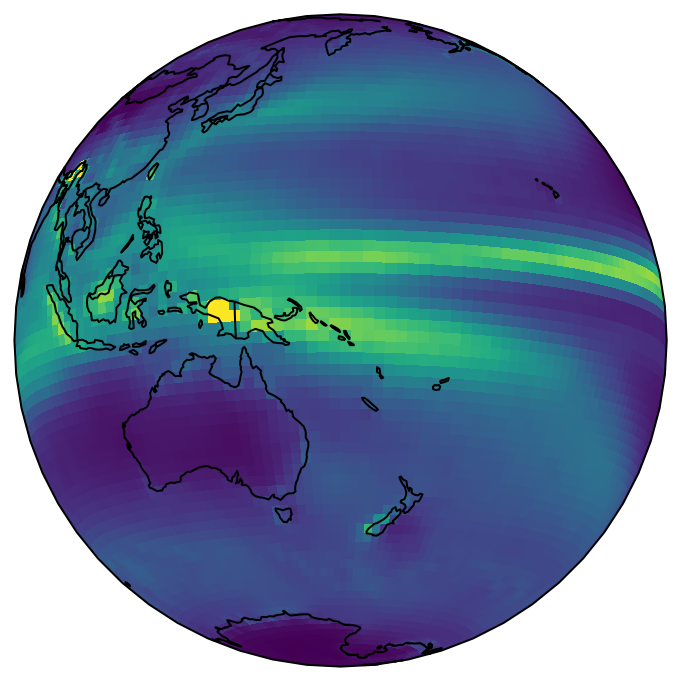

In [37]:
plt.figure(figsize=(12,6))
ax = plt.subplot(1, 1, 1, projection=ortho)
q = era['pr'].plot(vmin=0., vmax=1.5e-4, transform = geo)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')

q.colorbar.remove()
plt.savefig(f"../figures/globe_era-pr_for-ppt.png",bbox_inches='tight',dpi=200, transparent=True)

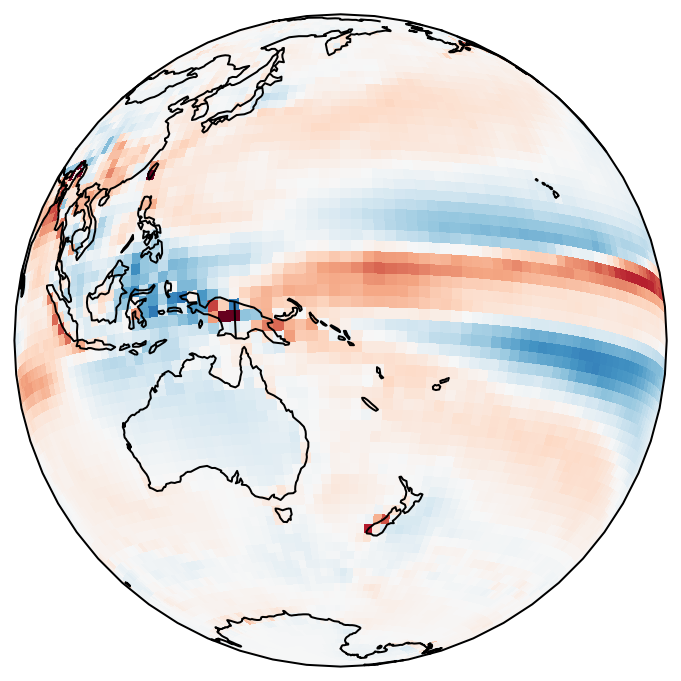

In [64]:
plt.figure(figsize=(12,6))
ax = plt.subplot(1, 1, 1, projection=ortho)
q = (era['pr'] - ens_dict['cmip6']['pr'].sel(ensemble='ens-mean')).plot(vmin=-0.5e-4, vmax=0.5e-4, transform = geo, cmap='RdBu_r')
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
plt.title("")

q.colorbar.remove()
plt.savefig(f"../figures/globe_bias-pr_for-ppt.png",bbox_inches='tight',dpi=200, transparent=True)

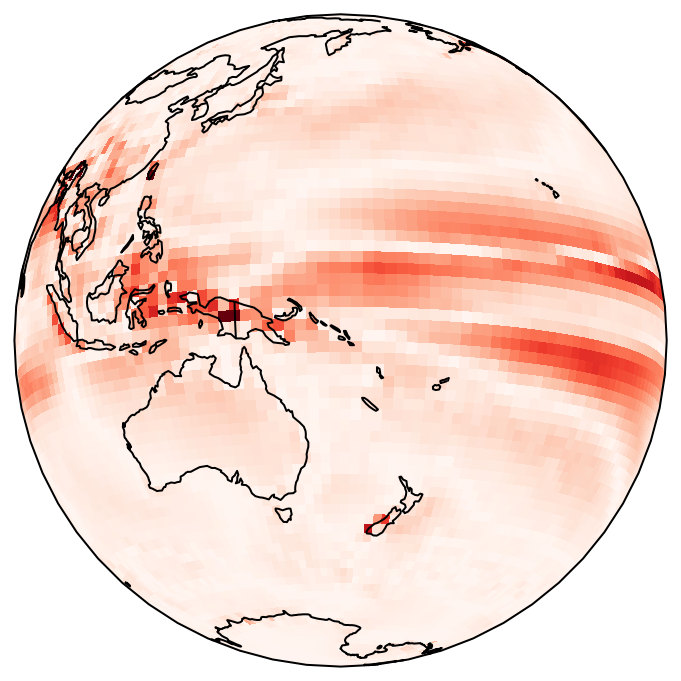

In [69]:
plt.figure(figsize=(12,6))
ax = plt.subplot(1, 1, 1, projection=ortho)
q = np.abs(era['pr'] - ens_dict['cmip6']['pr'].sel(ensemble='ens-mean')).plot(vmin=0., vmax=0.5e-4, transform = geo, cmap='Reds')
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
plt.title("")

q.colorbar.remove()
plt.savefig(f"../figures/globe_absolute-bias-pr_for-ppt.png",bbox_inches='tight',dpi=200, transparent=True)

In [61]:
mae_dict['cmip6'].sel(ensemble='ens-mean')

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    ensemble  <U8 'ens-mean'
Data variables:
    pr        float64 5.564e-06

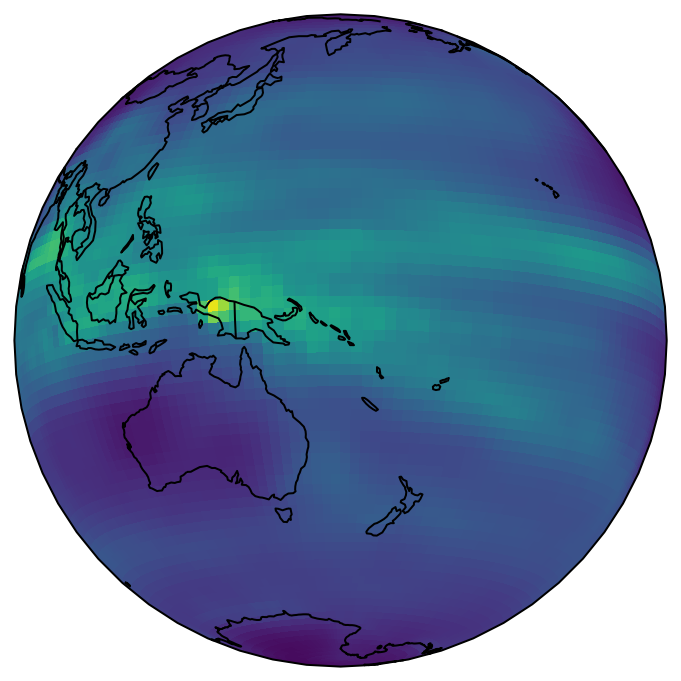

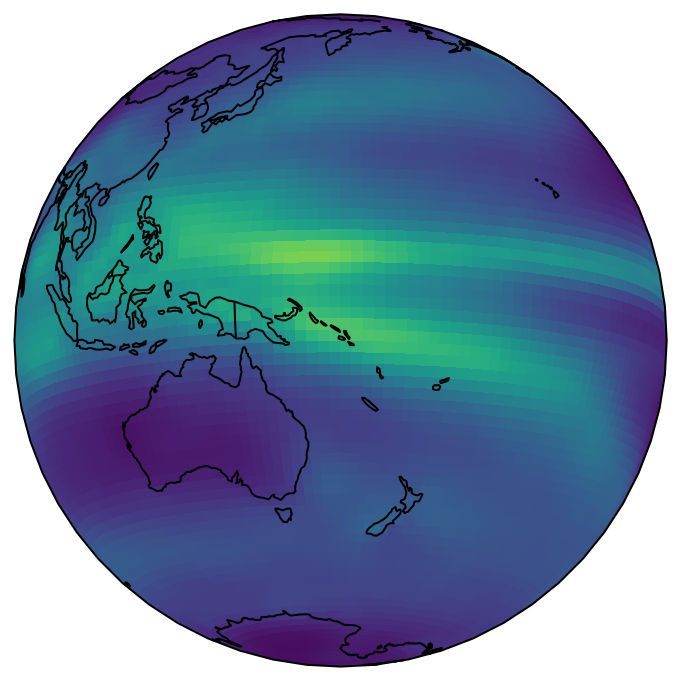

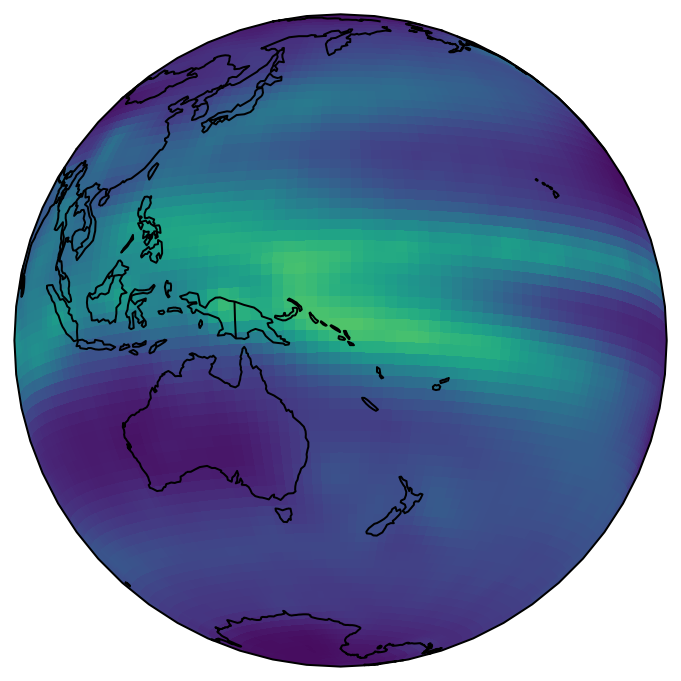

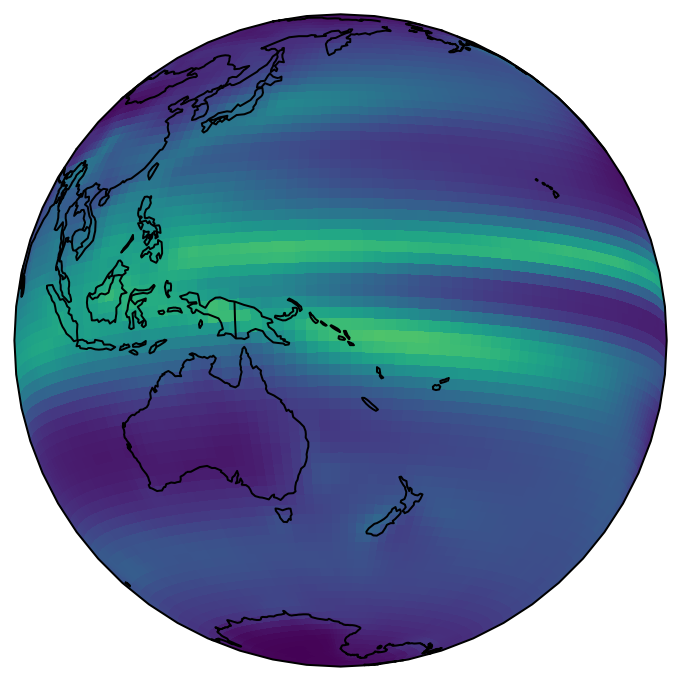

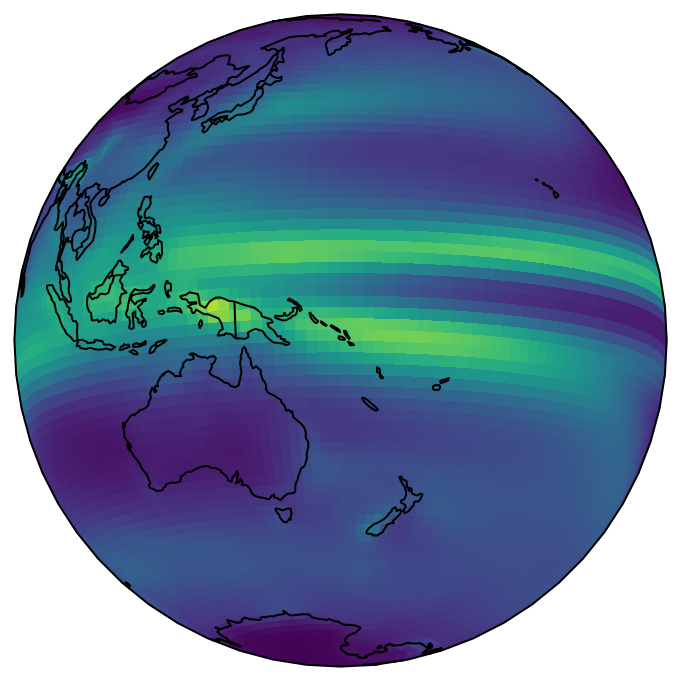

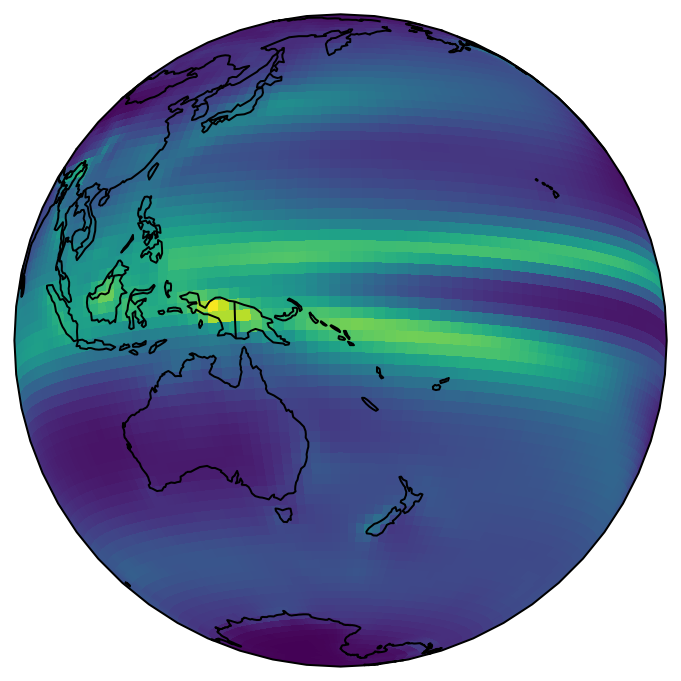

In [40]:
for key, ens in tqdm(ens_dict.items()):
    plt.figure(figsize=(12,6))
    ax = plt.subplot(1, 1, 1, projection=ortho)
    q = ens.sel(ensemble='ens-mean')['pr'].plot(vmin=0., vmax=1.5e-4, transform = geo)
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-')

    q.colorbar.remove()
    plt.title("")
    plt.savefig(f"../figures/globe_{key}-pr_for-ppt.png",bbox_inches='tight',dpi=200, transparent=True)

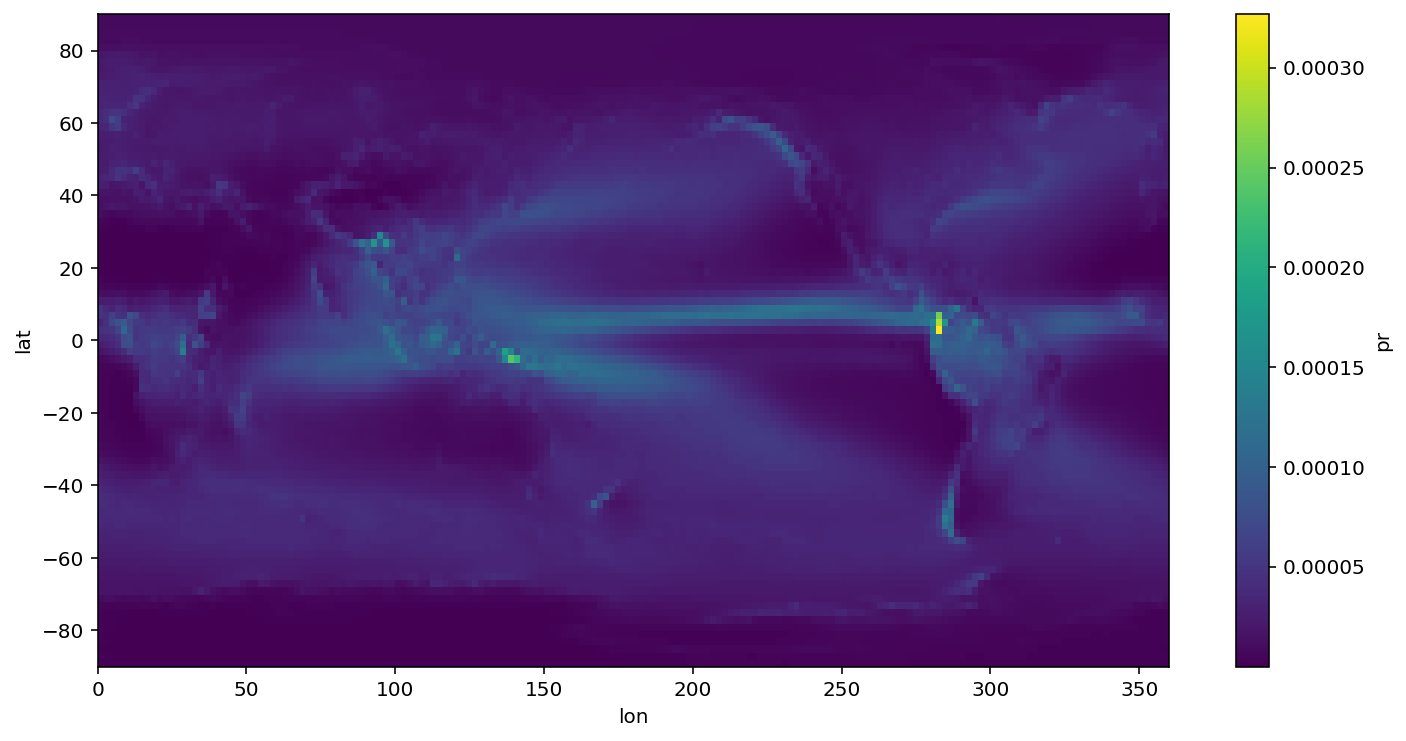

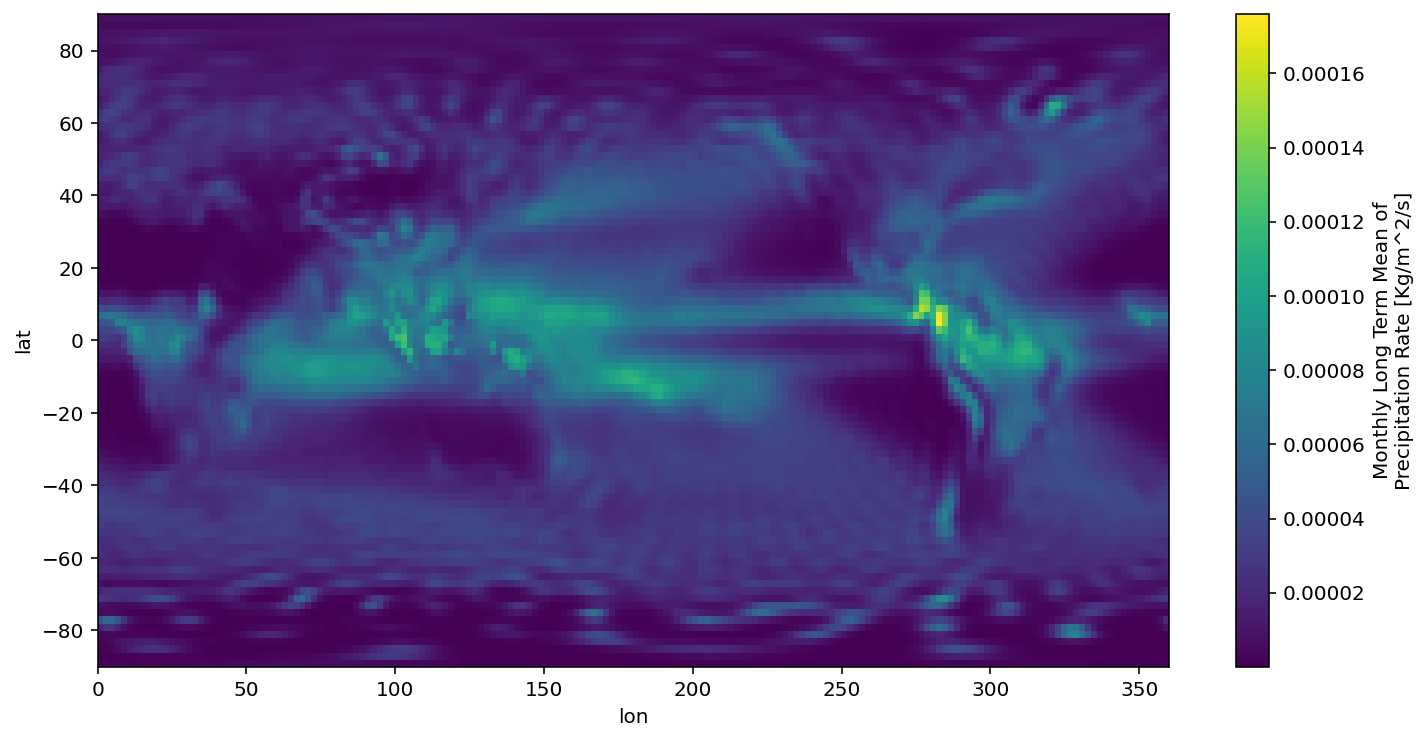

In [28]:
plt.figure(figsize=(12,6*len(plot_varnames)))
for i, varname in enumerate(plot_varnames, start=1):
    plt.subplot(len(plot_varnames),1,i)
    era[varname].plot()
    plt.savefig(f"../figures/mean-state_{varname}-ERA5.png",bbox_inches='tight',dpi=100)
    
plt.figure(figsize=(12,6*len(plot_varnames)))
for i, varname in enumerate(plot_varnames, start=1):
    plt.subplot(len(plot_varnames),1,i)
    ncep[varname].plot()
    plt.savefig(f"../figures/mean-state_{varname}-NCEP.png",bbox_inches='tight',dpi=100)

## Computing skill metrics

Plotting utilities

In [53]:
def carpet_plot(ds, varnames):
    size_y = len(ds.data_vars)+1
    array = np.zeros((size_y, ds.ensemble.size))
    for n, var in enumerate(list(ds.data_vars)):
        array[n,:] = ds[var].values
    array[-1,:] = np.nanmean(array[:-1,:], axis=0)  # average over all variables
    q = plt.pcolormesh(array, cmap='RdYlBu_r')
    plt.xticks(np.arange(ds.ensemble.size)+0.5, ds.ensemble.values, rotation=90.)
    plt.yticks(np.arange(size_y)+0.5, list(ds.data_vars) + ['combined'], rotation=0.)
    plt.colorbar()
    plt.clim([0.0,2.0])
    return q

## Mean absolute error

In [54]:
mae_dict = {}
#  Now applying area weighting to this metric
for key, ens in tqdm(ens_dict.items()):
    ens_tmp = ens.drop([var for var in list(ens.data_vars) if var not in plot_varnames])
    mae_dict[key] = xs.mae(obs.drop([var for var in list(obs.data_vars) if var not in list(ens_tmp.data_vars)]),
                           ens_tmp,
                           ['lat', 'lon'], weights=area).compute()

In [55]:
# TAR median
mae_med = mae_dict['far'].sel(ensemble=[key for key in mae_dict['far'].ensemble.values if key!='ens-mean']).median(dim='ensemble', skipna=True).compute()

mae_skill_score_dict = {}
for key in mae_dict.keys():
    mae = mae_dict[key]
    skill_score = mae/mae_med
    mae_skill_score_dict[key] = skill_score

In [47]:
ncep_mae = xs.mae(obs['pr'], ncep['pr'], ['lat', 'lon'], weights=area).compute()
ncep_mae_skill_score = ncep_mae/mae_med

shift_mae = xs.mae(obs['pr'], era_shift['pr'], ['lat', 'lon'], weights=area).compute()
shift_mae_skill_score = shift_mae/mae_med

In [37]:
if False:
    plt.figure(figsize=(15,26))
    subplot_count = 1
    for key, ens in ens_dict.items():
        plt.subplot(len(ens_dict), 1, subplot_count)
        q = carpet_plot(mae_skill_score_dict[key], plot_varnames)
        plt.title("Climate model skill metrics in "+key)
        q.colorbar.set_label("normalized mean\nabsolute error")
        subplot_count +=1

    plt.tight_layout()
    plt.savefig("../figures/model_performance_carpet.png",bbox_inches='tight',dpi=100)

# Skill metrics over time

In [38]:
mip_year_dict = {'far': 1990,
                 'sar': 1996,
                 'tar': 2000,
                 'cmip3': 2005,
                 'cmip5': 2013,
                 'cmip6': 2019}

mip_col = {'far': 'C5',
           'sar': 'C4',
           'tar': 'C3',
           'cmip3': 'C2',
           'cmip5': 'C1',
           'cmip6': 'C0'}

/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a pr

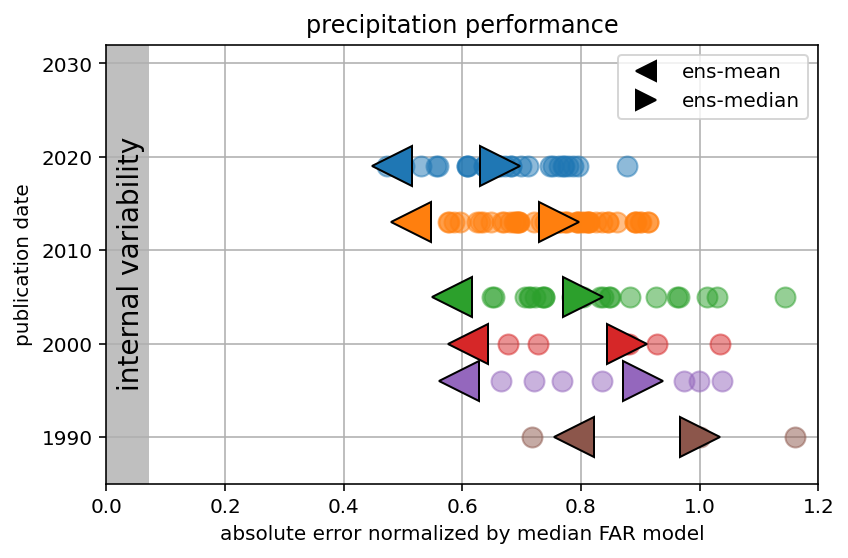

In [103]:
plt.figure(figsize=(6,4))

plt.subplot(len(plot_varnames),1,1)
ens_mean_label = "ens-mean"
plt.plot([], [], 'k<', markersize=10, label=ens_mean_label)
plt.plot([], [], 'k>', markersize=10, label='ens-median')

for key, ens in ens_dict.items():
    
    subplot_count = 1
    for var_key in plot_varnames:
        
        if var_key not in mae_dict[key]: continue

        ens_label = None
            
        plt.subplot(len(plot_varnames),1,subplot_count)
        
        not_mean_list = [key for key in ens.ensemble.values if key!='ens-mean']
        data = mae_skill_score_dict[key][var_key].sel(ensemble=not_mean_list)
        plt.plot(data,mip_year_dict[key]*np.ones_like(data),
                 'o', markersize=10, alpha=0.5, label=ens_label, color=mip_col[key])

        data = mae_skill_score_dict[key][var_key].sel(ensemble='ens-mean')
        plt.plot(data, mip_year_dict[key]*np.ones_like(data),
             marker='<', markersize=20, color=mip_col[key], markeredgecolor='k')
        
        data = mae_skill_score_dict[key][var_key].sel(
            ensemble=[e for e in list(mae_skill_score_dict[key].ensemble.values) if ('ens-mean' != e)]
        ).median(skipna=True)
        plt.plot(data, mip_year_dict[key]*np.ones_like(data),
             marker='>', markersize=20, color=mip_col[key], markeredgecolor='k')
        
        subplot_count+=1

for subplot_count in range(len(plot_varnames)):
    
    plt.subplot(len(plot_varnames),1,subplot_count+1)
    plt.ylim([1985,2032])
    plt.xlim([0., 1.2])
    plt.ylabel('publication date')
    plt.xlabel('absolute error normalized by median FAR model')
    plt.legend()
    plt.title('precipitation performance')
    plt.grid(True)
    
    plt.fill_between([0., shift_mae_skill_score['pr'].values], [1985., 1985.], [2032., 2032.], facecolor='grey', alpha=0.5)
    plt.annotate(s = "internal variability", xy=(0.015, 0.225), xycoords="axes fraction", rotation=90., fontsize=14)
    
plt.tight_layout()
plt.savefig("../figures/model_performance_over_time_for-powerpoint.png",bbox_inches='tight',dpi=250)